# Stations Dist
By Cascade Tuholske  

Notebook takes GCHN/GSOD stations and figures out how many people live within buffered distances from them using GHSL-Pop 2015

In [1]:
import os
import rasterio
from rasterio import features
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point 
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import square
from skimage.morphology import dilation

### Turn CHIRTS-daily GHCN/GSOD stations into a raster

In [2]:
stations_fn = os.path.join('/Users/cpt2136/Github/UrbanHeat/data/CHIRTS-daily/ValidationData/Validated/GHCN-and-GSOD-CHIRTSTmax_ERA5_meta-with-validation.csv')
stations = pd.read_csv(stations_fn)
stations.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
stations.head()

,latitudes,longitudes,elevations,country_seqnums,station_seqnums,cn_st_seqnums,hottest3,CHIRTS_cor,CHIRTS_mae,CHIRTS_sigdif,Princeton_cor,Princeton_mae,Princeton_sigdif,source
0,-34.4478,116.043,174,150,100009,150100009,1.0,0.967057,0.872308,-0.098095,0.805001,2.308543,-0.803658,GHCN
1,-32.4400,116.074,286,150,100028,150100028,1.0,0.956613,0.987142,-0.100106,0.869387,1.869749,0.318944,GHCN
2,-32.1083,116.925,199,150,100042,150100042,12.0,0.973448,0.789935,-0.127166,0.904122,1.651555,0.514729,GHCN
3,-32.5336,117.083,297,150,100061,150100061,12.0,0.973918,0.775232,-0.128055,0.906823,1.633426,0.509606,GHCN
4,-34.5683,116.337,210,150,100078,150100078,1.0,0.974630,0.906238,-0.493786,0.798112,2.401256,-1.250025,GHCN


In [3]:
len(stations)

15713

In [4]:
# Turn into gdf
# creating a geometry column 
stations['geometry'] = [Point(xy) for xy in zip(stations['longitudes'], stations['latitudes'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
stations_gdf = gpd.GeoDataFrame(stations, crs=crs)

/Users/cpt2136/miniconda3/envs/geo38/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

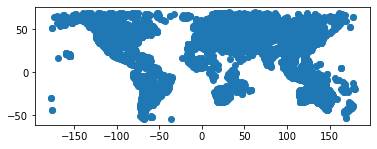

In [5]:
stations_gdf.plot()

In [10]:
# get geom and make column 1
polys = gpd.GeoDataFrame(stations_gdf['geometry'])
polys['ID'] = 1
polys.head()

,geometry,ID
0,POINT (116.04300 -34.44780),1
1,POINT (116.07400 -32.44000),1
2,POINT (116.92500 -32.10830),1
3,POINT (117.08300 -32.53360),1
4,POINT (116.33700 -34.56830),1


#### Buffer stations

In [44]:
# try buffering by 0.01° ~ 1km
buffer_1k = gpd.GeoDataFrame(geometry = polys.buffer(0.01))
buffer_1k['ID'] = 1
buffer_1k.head()

<ipython-input-44-c141a0446a56>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer_1k = gpd.GeoDataFrame(geometry = polys.buffer(0.01))


,geometry,ID
0,"POLYGON ((116.05300 -34.44780, 116.05295 -34.4...",1
1,"POLYGON ((116.08400 -32.44000, 116.08395 -32.4...",1
2,"POLYGON ((116.93500 -32.10830, 116.93495 -32.1...",1
3,"POLYGON ((117.09300 -32.53360, 117.09295 -32.5...",1
4,"POLYGON ((116.34700 -34.56830, 116.34695 -34.5...",1


In [32]:
#buffer_1k.to_file(os.path.join('../data/interim/GHCN-GSOD-5km.shp'))

#### Burn Array

In [45]:
# Burn array
ghs_fn = os.path.join('/Users/cpt2136/Github/PopGridCompare/data/interim/GHS15_matched.tif') 
ghs = rasterio.open(ghs_fn) # base map

meta = ghs.meta.copy() # copy meta data from rst
arr = ghs.read(1) # get an array to burn shapes
arr.fill(0) # revalue rst to an Nan Value before burning in polygons 

# extract geom and values to burn
shapes = ((geom,value) for geom, value in zip(buffer_1k['geometry'], polys['ID'])) 

# burn shapes into an array - Using no touch see rasterstats zonal stats documentation for justification 
burned = features.rasterize(shapes=shapes, fill=0, out=arr, transform=ghs.transform, all_touched=False)

In [46]:
# write the raster
# out_fn = os.path.join('../data/interim/GHCN-GSOD-5km.tif')
# with rasterio.open(out_fn, 'w', **meta) as out:
#     out.write_band(1, burned)

In [47]:
# How many people live within 5 km of a station
ghs_pop = ghs.read(1) # get population
ghs_pop[ghs_pop == -999] = 0 # re set neg values
pop_sum = burned * ghs_pop

In [48]:
ans = pop_sum .flatten().sum()
print('How many people within ~5 km', ans/10**6, ' million')

How many people within ~5 km 38.830341638166324  million


## Five km

In [ ]:
burned_1k = dilation(burned, square(3))

In [ ]:
# write the raster
out_fn = os.path.join('/Users/cpt2136/Github/GeoClim/data/interim/stations/ghcn-gsod-rst-1k.tif')
with rasterio.open(out_fn, 'w', **meta) as out:
    out.write_band(1, burned_1k)